In [ ]:

import time
import random
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple

PIT_STOP_TIME = 23.0


In [ ]:
@dataclass
class TireCompound:
    name: str
    base_lap_time: float
    degradation_params: Tuple[float, float, int]  # (initial_rate, mid_race_rate, cliff_lap)
    max_life: int

    def lap_time(self, lap: int, stint_start_lap: int) -> float:
        laps_into_stint = lap - stint_start_lap
        if laps_into_stint >= self.max_life:
            return float('inf')  # Tire failure

        init_rate, mid_rate, cliff = self.degradation_params
        if laps_into_stint < cliff:
            degradation = init_rate * laps_into_stint
        else:
            degradation = (init_rate * cliff) + mid_rate * (laps_into_stint - cliff)

        return self.base_lap_time + degradation


In [ ]:
# Single, consistent definitions for compounds
SOFT = TireCompound("Soft", 90.0, (0.08, 0.15, 12), 22)
MEDIUM = TireCompound("Medium", 90.5, (0.04, 0.10, 18), 32)
HARD = TireCompound("Hard", 91.0, (0.02, 0.06, 25), 45)

COMPOUNDS = [SOFT, MEDIUM, HARD]


class PitStopStrategy:
    """Represents a pit stop strategy"""
    def __init__(self):
        self.stops: List[Tuple[int, TireCompound]] = []  # List of (lap_number, compound) tuples
        self.total_time: float = 0.0

    def add_stop(self, lap: int, compound: TireCompound):
        self.stops.append((lap, compound))

    def __repr__(self):
        stops_str = ", ".join([f"Lap {lap}: {compound.name}" for lap, compound in self.stops])
        return f"Strategy: {stops_str or 'No stops'} | Total Time: {self.total_time:.2f}s"


In [ ]:
def calculate_race_time(strategy: PitStopStrategy, total_laps: int, starting_compound: TireCompound) -> float:
    """Calculate total race time for a given strategy"""
    total_time = 0.0
    current_lap = 1
    current_compound = starting_compound
    stint_start = 1

    # Sort stops by lap number
    stops = sorted(strategy.stops, key=lambda x: x[0])
    # Add an end marker so the final stint is processed
    stops.append((total_laps + 1, None))

    for stop_lap, next_compound in stops:
        # Ensure we don't iterate beyond race
        for lap in range(current_lap, min(stop_lap, total_laps + 1)):
            total_time += current_compound.lap_time(lap, stint_start)

        # Add pit stop time if not at race end
        if stop_lap <= total_laps:
            total_time += PIT_STOP_TIME
            current_compound = next_compound
            stint_start = stop_lap + 1
            current_lap = stop_lap + 1

    return total_time


In [ ]:
def brute_force_strategy(total_laps: int, max_stops: int = 3) -> Tuple[PitStopStrategy, float]:
    """
    Brute force approach: Try sampled pit stop lap combinations.
    Returns best strategy and elapsed runtime.
    """
    start_time = time.time()

    best_strategy = None
    best_time = float('inf')

    # Generate stop lap combinations but sample every 5 laps to limit search
    def generate_strategies(num_stops):
        if num_stops == 0:
            return [[]]
        strategies = []
        # Start at lap 5, allow stops up to total_laps - 5 * remaining stints
        for first_stop in range(5, max(6, total_laps - 5 * num_stops + 1), 5):
            for rest in generate_strategies(num_stops - 1):
                if not rest or first_stop < rest[0]:
                    strategies.append([first_stop] + rest)
        return strategies

    # Try different numbers of stops
    for num_stops in range(0, max_stops + 1):
        stop_combinations = generate_strategies(num_stops)

        for stop_laps in stop_combinations:
            # For each stop combination, try all compound sequences (including starting compound)
            def generate_compound_sequences(length):
                if length == 0:
                    return [[]]
                sequences = []
                for compound in COMPOUNDS:
                    for rest in generate_compound_sequences(length - 1):
                        sequences.append([compound] + rest)
                return sequences

            compound_sequences = generate_compound_sequences(num_stops + 1)

            for compounds in compound_sequences:
                # Ensure at least two different compounds are used if there is any stop (mirrors F1 rule)
                if num_stops > 0 and len(set(c.name for c in compounds)) < 2:
                    continue

                strategy = PitStopStrategy()
                starting_compound = compounds[0]

                for i, stop_lap in enumerate(stop_laps):
                    strategy.add_stop(stop_lap, compounds[i + 1])

                race_time = calculate_race_time(strategy, total_laps, starting_compound)

                if race_time < best_time:
                    best_time = race_time
                    best_strategy = strategy
                    best_strategy.total_time = race_time

    elapsed_time = time.time() - start_time
    # If no strategy found (shouldn't happen), return an empty strategy
    if best_strategy is None:
        best_strategy = PitStopStrategy()
        best_strategy.total_time = calculate_race_time(best_strategy, total_laps, SOFT)

    return best_strategy, elapsed_time


In [ ]:
def greedy_strategy(race_laps, min_stint_length=5, pit_loss=PIT_STOP_TIME) -> Tuple[PitStopStrategy, float]:
    """
    Simple greedy: start on SOFT, consider pitting at each lap (after min_stint_length),
    choose the single best compound to switch to for the remainder of the race if it improves
    total remaining time (accounts for pit_loss).
    """
    start_time = time.time()
    strategy = PitStopStrategy()
    current_compound = SOFT
    stint_start = 1
    pit_count = 0  # Add counter for number of pit stops

    for lap in range(1, race_laps + 1):
        if lap - stint_start < min_stint_length:
            continue

        if pit_count >= 2:  # Stop considering more pit stops after 3
            break

        stay_time = sum(current_compound.lap_time(l, stint_start) for l in range(lap, race_laps + 1))

        best_pit_time = float('inf')
        best_compound = None

        for compound in COMPOUNDS:
            if compound is current_compound:
                continue
            pit_time = pit_loss
            pit_time += sum(compound.lap_time(l, lap + 1) for l in range(lap + 1, race_laps + 1))
            if pit_time < best_pit_time:
                best_pit_time = pit_time
                best_compound = compound

        if (best_compound is not None and
            best_pit_time < stay_time * 0.98 and
            lap - stint_start >= min_stint_length and
            race_laps - lap >= min_stint_length):
            strategy.add_stop(lap, best_compound)
            current_compound = best_compound
            stint_start = lap + 1
            pit_count += 1  # Increment pit counter

    total = calculate_race_time(strategy, race_laps, SOFT)
    strategy.total_time = total
    elapsed_time = time.time() - start_time
    return strategy, elapsed_time


In [ ]:

def fixed_strategy(total_laps: int) -> Tuple[PitStopStrategy, float]:
    """
    Fixed 2-stop strategy: Pit at predetermined intervals
    """
    start_time = time.time()

    strategy = PitStopStrategy()
    stop1 = max(5, total_laps // 3)
    stop2 = min(total_laps - 5, 2 * total_laps // 3)

    strategy.add_stop(stop1, MEDIUM)
    strategy.add_stop(stop2, HARD)

    race_time = calculate_race_time(strategy, total_laps, SOFT)
    strategy.total_time = race_time

    elapsed_time = time.time() - start_time
    return strategy, elapsed_time



In [ ]:
def run_experiments():
    """Run experiments comparing different strategies"""
    print("=" * 80)
    print("F1 PIT STOP STRATEGY OPTIMIZATION")
    print("=" * 80)

    # Test with different race lengths
    race_lengths = [30, 40, 50, 60]

    greedy_times = []
    brute_force_times = []
    fixed_times = []

    greedy_runtimes = []
    brute_force_runtimes = []

    for laps in race_lengths:
        print(f"\n{'=' * 80}")
        print(f"RACE LENGTH: {laps} LAPS")
        print(f"{'=' * 80}")

        # Greedy Strategy
        print("\n[1] GREEDY ALGORITHM:")
        greedy_strategy_result, greedy_runtime = greedy_strategy(laps)
        print(f"    {greedy_strategy_result}")
        print(f"    Runtime: {greedy_runtime:.6f} seconds")
        greedy_times.append(greedy_strategy_result.total_time)
        greedy_runtimes.append(greedy_runtime)

        # Fixed Strategy
        print("\n[2] FIXED 2-STOP STRATEGY:")
        fixed_strategy_result, fixed_runtime = fixed_strategy(laps)
        print(f"    {fixed_strategy_result}")
        print(f"    Runtime: {fixed_runtime:.6f} seconds")
        fixed_times.append(fixed_strategy_result.total_time)

        # Brute Force (only for smaller races due to complexity)
        if laps <= 60:
            print("\n[3] BRUTE FORCE (sampling):")
            brute_force_result, brute_force_runtime = brute_force_strategy(laps, max_stops=2)
            print(f"    {brute_force_result}")
            print(f"    Runtime: {brute_force_runtime:.6f} seconds")
            brute_force_times.append(brute_force_result.total_time)
            brute_force_runtimes.append(brute_force_runtime)
        else:
            print("\n[3] BRUTE FORCE: Skipped (too computationally expensive)")
            brute_force_times.append(None)
            brute_force_runtimes.append(None)

        # Compare strategies (guard against division by zero)
        improvement = ((fixed_strategy_result.total_time - greedy_strategy_result.total_time) /
                       fixed_strategy_result.total_time * 100) if fixed_strategy_result.total_time > 0 else 0.0
        print(f"\n{'=' * 80}")
        print(f"Greedy vs Fixed: {improvement:.2f}% faster")
        print(f"Time saved: {fixed_strategy_result.total_time - greedy_strategy_result.total_time:.2f} seconds")

    # Create visualizations
    create_visualizations(race_lengths, greedy_times, fixed_times, brute_force_times,
                          greedy_runtimes, brute_force_runtimes)


In [ ]:
def create_visualizations(race_lengths, greedy_times, fixed_times, brute_force_times,
                          greedy_runtimes, brute_force_runtimes, save_path='runtime_comparison.png'):
    """Create runtime comparison plot only and save it"""
    fig, ax1 = plt.subplots(figsize=(8, 5))

    # Filter out None values for brute force
    valid_bf_runtime = [(l, t) for l, t in zip(race_lengths, brute_force_runtimes) if t is not None]

    # Plot Greedy runtimes
    ax1.plot(race_lengths, [t * 1000 for t in greedy_runtimes], 'go-',
             linewidth=2, markersize=8, label='Greedy')

    # Plot Brute Force runtimes if available
    if valid_bf_runtime:
        bf_laps, bf_rt = zip(*valid_bf_runtime)
        ax1.plot(bf_laps, [t * 1000 for t in bf_rt], 'ro-',
                 linewidth=2, markersize=8, label='Brute Force')

    ax1.set_xlabel('Race Length (laps)', fontsize=11)
    ax1.set_ylabel('Runtime (milliseconds)', fontsize=11)
    ax1.set_title('Runtime Comparison (Linear Scale)', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Save figure to file
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nRuntime comparison plot saved as '{save_path}'")

    # Print summary statistics
    print("\n" + "=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)
    if valid_bf_runtime:
        bf_laps, bf_rt = zip(*valid_bf_runtime)
        speedups = [bf_t / greedy_runtimes[race_lengths.index(lap)]
                   for lap, bf_t in zip(bf_laps, bf_rt)]
        print(f"Average speedup: {np.mean(speedups):.1f}x")
        print(f"Maximum speedup: {np.max(speedups):.1f}x (at {bf_laps[np.argmax(speedups)]} laps)")
    print(f"Greedy total runtime: {sum(greedy_runtimes)*1000:.2f} ms")
    if valid_bf_runtime:
        print(f"Brute force total runtime: {sum(bf_rt)*1000:.2f} ms")
    print("=" * 80)

    plt.show()



In [ ]:

def demonstrate_limitations():
    """Demonstrate limitations of greedy approach"""
    print("\n" + "=" * 80)
    print("DEMONSTRATING GREEDY ALGORITHM LIMITATIONS")
    print("=" * 80)

    total_laps = 50

    # Scenario 1: Normal race
    print("\n[Scenario 1] NORMAL RACE CONDITIONS:")
    strategy1, _ = greedy_strategy(total_laps)
    print(f"    {strategy1}")

    # Scenario 2: Simulate safety car effect
    print("\n[Scenario 2] SAFETY CAR ON LAP 25 (reduces pit cost to ~5 seconds):")
    print("    In reality, teams would pit during safety car to minimize time loss.")
    print("    Greedy algorithm cannot anticipate this and may pit sub-optimally earlier.")
    print("    → Limitation: Cannot predict future events")

    # Scenario 3: Opponent strategy
    print("\n[Scenario 3] OPPONENT PITS EARLY (LAP 15) FOR 'UNDERCUT':")
    print("    Greedy algorithm ignores opponent strategy.")
    print("    Real teams may respond by pitting earlier than optimal to protect position.")
    print("    → Limitation: No game-theoretic reasoning")

    # Scenario 4: Weather change
    print("\n[Scenario 4] RAIN FORECAST FOR LAP 40:")
    print("    Should extend current stint and pit directly for wet tires.")
    print("    Greedy algorithm will pit based on current conditions only.")
    print("    → Limitation: No weather forecasting integration")

    print("\n" + "=" * 80)
    print("CONCLUSION: Real F1 teams use sophisticated simulation platforms that:")
    print("  • Run Monte Carlo simulations for probabilistic scenarios")
    print("  • Model opponent strategies (game theory)")
    print("  • Integrate weather forecasts and telemetry")
    print("  • Use dynamic programming for global optimization")
    print("=" * 80)


F1 PIT STOP STRATEGY OPTIMIZATION

RACE LENGTH: 30 LAPS

[1] GREEDY ALGORITHM:
    Strategy: Lap 6: Medium, Lap 12: Soft | Total Time: 2582.99s
    Runtime: 0.000156 seconds

[2] FIXED 2-STOP STRATEGY:
    Strategy: Lap 10: Medium, Lap 20: Hard | Total Time: 2585.72s
    Runtime: 0.000020 seconds

[3] BRUTE FORCE (sampling):
    Strategy: Lap 10: Medium, Lap 20: Soft | Total Time: 2578.42s
    Runtime: 0.006686 seconds

Greedy vs Fixed: 0.11% faster
Time saved: 2.73 seconds

RACE LENGTH: 40 LAPS

[1] GREEDY ALGORITHM:
    Strategy: Lap 6: Hard, Lap 12: Medium | Total Time: 3503.82s
    Runtime: 0.000119 seconds

[2] FIXED 2-STOP STRATEGY:
    Strategy: Lap 13: Medium, Lap 26: Hard | Total Time: 3495.74s
    Runtime: 0.000021 seconds

[3] BRUTE FORCE (sampling):
    Strategy: Lap 15: Soft, Lap 30: Medium | Total Time: 3487.50s
    Runtime: 0.014158 seconds

Greedy vs Fixed: -0.23% faster
Time saved: -8.08 seconds

RACE LENGTH: 50 LAPS

[1] GREEDY ALGORITHM:
    Strategy: Lap 6: Hard, La

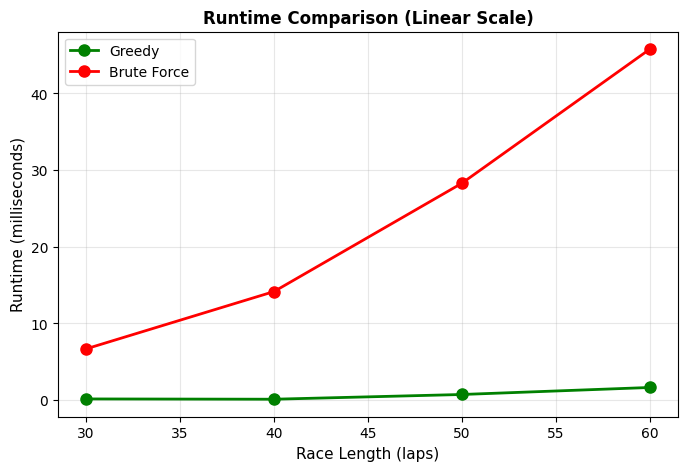


DEMONSTRATING GREEDY ALGORITHM LIMITATIONS

[Scenario 1] NORMAL RACE CONDITIONS:
    Strategy: Lap 6: Hard, Lap 18: Medium | Total Time: 4420.20s

[Scenario 2] SAFETY CAR ON LAP 25 (reduces pit cost to ~5 seconds):
    In reality, teams would pit during safety car to minimize time loss.
    Greedy algorithm cannot anticipate this and may pit sub-optimally earlier.
    → Limitation: Cannot predict future events

[Scenario 3] OPPONENT PITS EARLY (LAP 15) FOR 'UNDERCUT':
    Greedy algorithm ignores opponent strategy.
    Real teams may respond by pitting earlier than optimal to protect position.
    → Limitation: No game-theoretic reasoning

[Scenario 4] RAIN FORECAST FOR LAP 40:
    Should extend current stint and pit directly for wet tires.
    Greedy algorithm will pit based on current conditions only.
    → Limitation: No weather forecasting integration

CONCLUSION: Real F1 teams use sophisticated simulation platforms that:
  • Run Monte Carlo simulations for probabilistic scenarios

In [ ]:


if __name__ == "__main__":
    run_experiments()
    demonstrate_limitations()
    print("\n" + "=" * 80)
    print("EXPERIMENT COMPLETE")
    print("=" * 80)